In [64]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True):
    # cwd = os.getcwd() + "images"
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    # mode = "a" if os.path.exists(path) else "w"
    print("saving figure", fig_id)
    # 新建目录 不然也会报错
    # 新建png文件 不然找不到该文件会报错 chapter_id 手动创建
    if not os.path.isdir(os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)):
        os.makedirs(os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID))
    if not os.path.exists(path):
        with open(path, 'w'):
            pass
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format="png", dpi=300)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [65]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]
# 不用返回值，只是处理了一下mnist中标签乱序的问题

In [66]:
import ssl
# 没有下面的 会报错: SSL certification
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
    getattr(ssl, '_create_unverified_context', None)): 
    ssl._create_default_https_context = ssl._create_unverified_context

In [67]:
# ctrl + M: change mode of cell
# ctrl + o/k: 改变cell长度
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", version=1, cache=True) # cache 存到缓存中 第一次不对劲 再fetch就好了

In [68]:
mnist.target = mnist.target.astype(np.int8)
sort_by_target(mnist)
mnist["data"].shape
mnist["target"].shape

(70000,)

In [100]:
X, y = mnist["data"], mnist["target"] # mnist is Bunch, mnist["data"] = mnist.data
np.where(y==8)[0][10]

48210

In [70]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=mpl.cm.binary, interpolation="nearest")
    plt.axis("off")

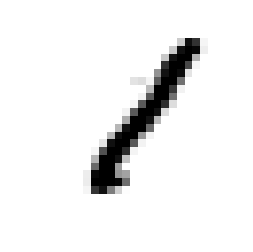

In [102]:
plot_digit(X[11999])

In [72]:
# 拼接单个图片 -> 行图片 -> 完整的x*x图片
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1 # e.g.: 10 -> 9 // 10 + 1 -> 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

saving figure more_digits_plot


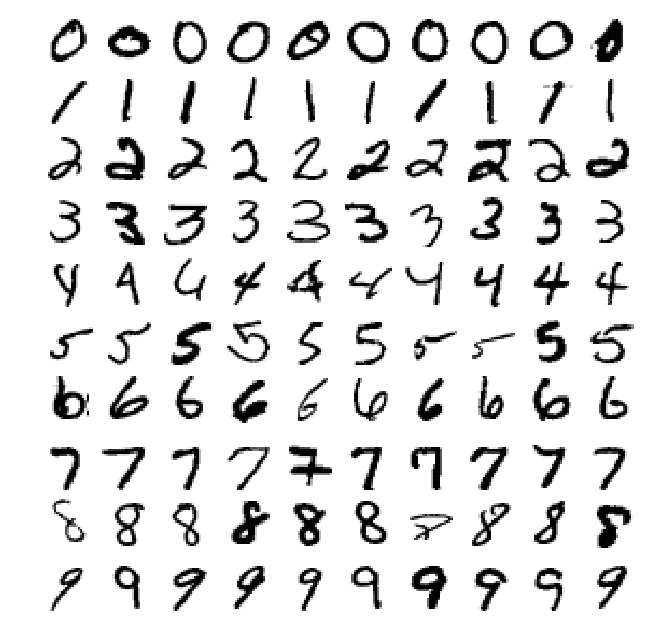

In [73]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]] # X[start:end:step] end is exclusive!
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

In [103]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [104]:
shuffle_index = np.random.permutation(60000)
X_train = X_train[shuffle_index]
y_train = y_train[shuffle_index]

In [110]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [111]:
from sklearn.linear_model import SGDClassifier # 线性分类器 sklearn中是linear svm，求解器为sgd

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=-inf,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [113]:
sgd_clf.predict([X[36000]]) # [] 不能少

array([ True])

#### classifier的评价指标

#### 1、交叉验证

In [121]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9502 , 0.96565, 0.96495])

In [126]:
from sklearn.base import BaseEstimator
# pred is all False
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [127]:
# 训练集中数据分布很不均衡的情况下，准确率并不是很好的评价指标，即使全猜false，也有90%的准确率
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.909  , 0.90715, 0.9128 ])

#### 2、confusion matrix

In [129]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)
# matrix: row1: not 5, col1: right pred
# 52373: true negatives, 1307: false positives, 1077: false negatives, 4344: true positives

array([[53272,  1307],
       [ 1077,  4344]])

3、precision & recall (based on **true positives**)

$precision = \frac{TP}{TP + FP}$分类器预测是5，准确率？$recall = \frac{TP}{TP + FN}$: 所有的tag是5的样本里，分类器预测对了多少？

In [131]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.7687135020350381

In [132]:
recall_score(y_train_5, y_train_pred)

0.801328168234643

In [133]:
4344/(1077+4344)

0.801328168234643

F<sub>1</sub>=$\Large\frac{2}{\frac{1}{precision} + \frac{1}{recall}}$: 综合了上面两个，但是是平等对待两者 if: 视频鉴黄 recall就比precision更重要，尽可能多的找出h的 -> 过滤掉

In [134]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7846820809248555

precision & recall **Tradeoff**

In [139]:
y_scores = sgd_clf.decision_function([X[36000]])

In [140]:
y_scores

array([161855.74572176])

In [141]:
# default threshold: 0, 增加threshold，recall肯定降低，precision大体上是增加的，中间稍有波动
threshold = 0
y_scores > threshold

array([ True])

In [146]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [150]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [155]:
precisions.shape

(59699,)

saving figure precision_recall_vs_threshold_plot


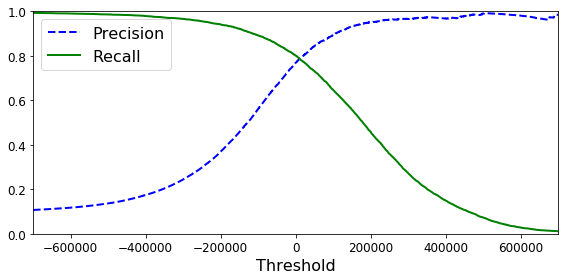

In [167]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], 'g-', label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc='upper left', fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
save_fig("precision_recall_vs_threshold_plot")
plt.show()

In [159]:
(y_train_pred == (y_scores>0)).all() # sgd默认的threshold: 0

True

In [160]:
y_train_pred_90 = (y_scores > 70000)
precision_score(y_train_5, y_train_pred_90) # labels vs around 90% precision threshold

0.8659205116491548

In [161]:
recall_score(y_train_5, y_train_pred_90)

0.6993174691016417

saving figure percision_vs_recall_plot


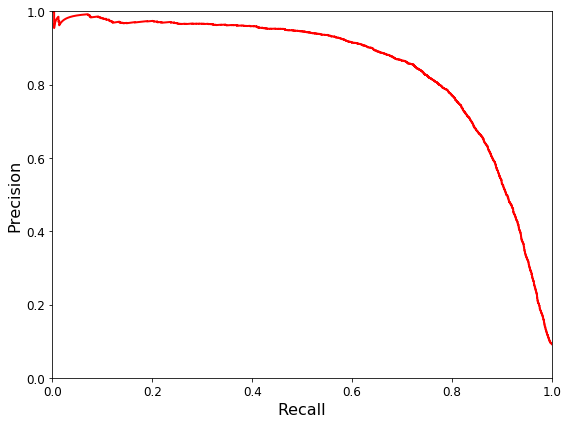

In [164]:
# 要求99%precision，要弄清recall是多少
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, 'r-', linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0,1,0,1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
save_fig("percision_vs_recall_plot")
plt.show()

#### 3、ROC 曲线(receiver operating characteristic)

ROC = $\frac{TPR}{NPR} = \frac{TPR}{1-NPR}$

In [185]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds= roc_curve(y_train_5, y_scores)

saving figure roc_curve_plot


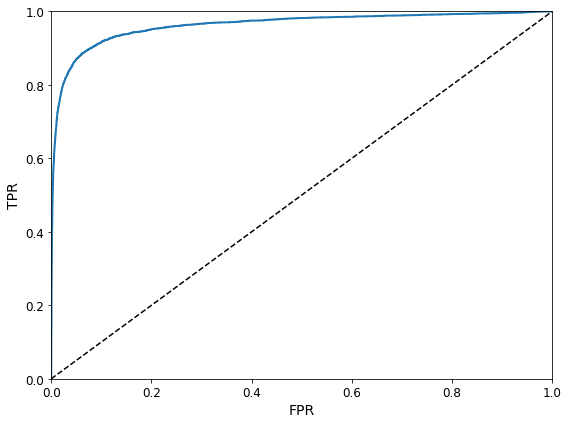

In [169]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.xlabel("FPR")
    plt.ylabel("TPR")

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
save_fig("roc_curve_plot")
plt.show()

TPR 越高，FPR就越搞，虚线是xjb分的结果，binary clf应该尽可能往左上角靠，即 **roc auc**越靠近1越好 (auc曲线下面积

In [170]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9624496555967156

#### 和RF的对比

In [172]:
from sklearn.ensemble import RandomForestClassifier
# sklearn的分类器 要么有decision_function方法 要么有predict_proba方法 随机森林predict_proba返回的是每个label的概率
forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)
probs_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [186]:
y_scores_forest = probs_forest[:,1]
fpr_forest, tpr_forest, threshold = roc_curve(y_train_5, y_scores_forest)

saving figure ROC_curve_comparision


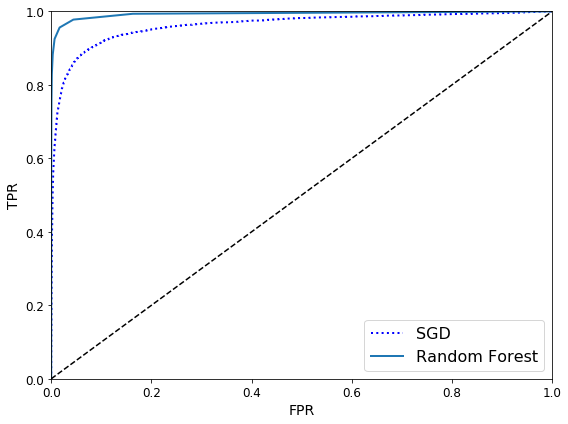

In [187]:
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, 'b:', linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, label="Random Forest")
plt.legend(loc="lower right", fontsize=16)
save_fig("ROC_curve_comparision")
plt.show()

In [188]:
roc_auc_score(y_train_5, y_scores_forest)

0.9931243366003829

In [189]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9852973447443494

In [190]:
recall_score(y_train_5, y_train_pred_forest)

0.8282604685482383

### Multiclass Classification: 多分类问题

#### OvA & OvO: MNIST为例，前者要在原训练集上训练10个binary classifier，谁给的分高就是该类。后者要在各自的子训练集中训练$C_{10}^{2}=45$个bianry classifier，用投票之类的组合方法确定结果
sklearn中自动选择OvA策略(除了SVM分类器用OvO，因为SVM分类器随着样本size的增加 性能变差 OvO只要在部分训练集上训练
#### 随机森林和naive Bayes分类器可以进行多分类，而SVM和线性分类器必须组合起来才能解决多分类问题

In [192]:
# sklearn 实际上训练了10个binary classifier，选择了decision score最高的分类器对应的class
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([X[36000]])

array([5], dtype=int8)

In [196]:
real_scores = sgd_clf.decision_function([X[36000]])
real_scores # 1*10 ndarray

In [197]:
np.argmax(real_scores)

5

In [199]:
sgd_clf.classes_[5] # classes_[5] 即5th分类器对应的class（碰巧class和index一样

5

In [201]:
# 使用OvO
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)) # 没指定max_iter和tol会出现warning
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([X[36000]])

array([5], dtype=int8)

In [202]:
len(ovo_clf.estimators_) # 训练了45个分类器

45

In [203]:
# 随机森林分类器
forest_clf.fit(X_train, y_train)
forest_clf.predict([X[36000]])

array([5], dtype=int8)

In [205]:
np.argmax(forest_clf.predict_proba([X[36000]]))

5

In [206]:
cross_val_score(forest_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.94041192, 0.93879694, 0.93949092])

In [207]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.84063187, 0.84899245, 0.86652998])

In [209]:
# 对训练集进行预处理, StandardScaler: z=(x-u)/s (u: mean, s: standard deviation)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.91011798, 0.90874544, 0.906636  ])

In [210]:
# error analysis
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
cf_matrix = confusion_matrix(y_train, y_train_pred)

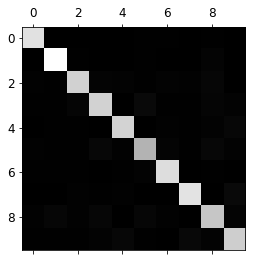

In [211]:
plt.matshow(cf_matrix, cmap=plt.cm.gray)
plt.show()

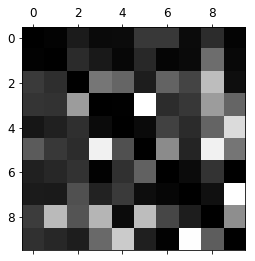

In [214]:
row_sums = cf_matrix.sum(axis=1, keepdims=True)
norm_cfm = cf_matrix / row_sums
np.fill_diagonal(norm_cfm, 0) # 不然对角值太高 其他的就看不明显了
plt.matshow(norm_cfm, cmap=plt.cm.gray)

saving figure error_analysis_digits_plot


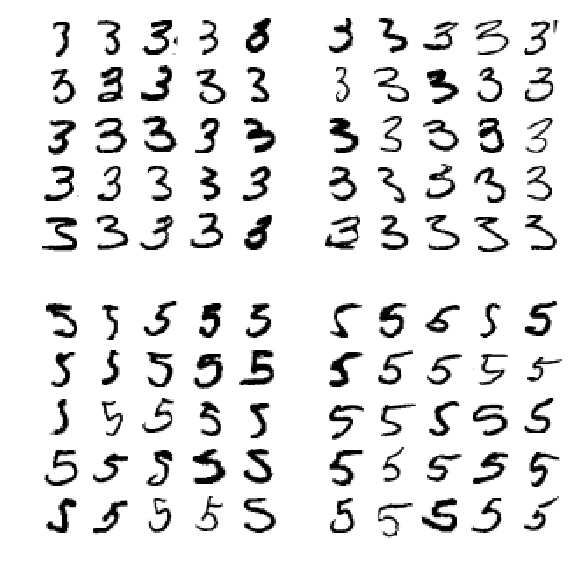

In [218]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)] # 3 误认为 5
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)] # 5 误认为 3
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5) # 一般是没有;的 同一行 分隔用
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

### Multilabels Classification

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
# KNN分类器特点: None-parametic, Lazy.训练过程只要把训练集记住就行 预测时根据k neighbors的投票进行分类（if回归 取k个邻居的mean
y_train_large = (y_train >= 7)
y_train_odd = (y_train%2=1)
y_train_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
# knn_clf.fit(X_train, y_train_multilabel) 
# cross_val_predict 过程比较耗时
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train_multilabel, cv=3, n_jobs=-1)
f1_score(y_train_multilabel, y_train_knn_pred, average="macro") # macro假设all标签同样重要|weighted给不同的label不同的权重 

### Multioutput Classification (multioutput-multiclass... 上面的延伸 输出的每个label也会有很多值

In [227]:
# e.g. 含噪音pic -> 降噪后的pic，输出的图片 每个pixel相当于一个label 每个label取值[0, 255]
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

saving figure noisy_digit_plot


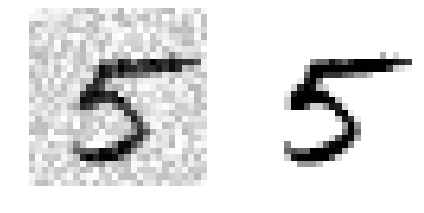

In [231]:
idx = 5500
plt.subplot(121); plot_digit(X_test_mod[idx])
plt.subplot(122); plot_digit(y_test_mod[idx])
save_fig("noisy_digit_plot")
plt.show()

saving figure clean_digit_plot


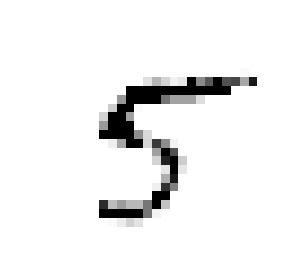

In [234]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[idx]]) # 加 [] !
plot_digit(clean_digit)
save_fig("clean_digit_plot")
plt.show()

#### KNN分类器

In [236]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_jobs=-1, weights="distance", n_neighbors=4) # -1: all cores distance:距离近 权重大
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
           weights='distance')

In [238]:
from sklearn.metrics import accuracy_score

y_test_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_test_pred) # 大约2min

0.9714

In [239]:
from scipy.ndimage.interpolation import shift

def shift_digit(digit_array, dx, dy, new=0): # new 指新出来的 input之外的点的默认值
    return shift(digit_array.reshape([28, 28]), [dy, dx], cval=new).reshape(784) # dx, dy -> dy, dx

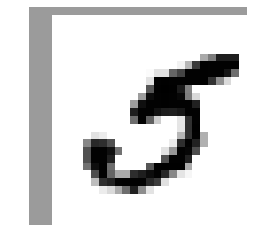

In [249]:
plot_digit(shift_digit(X[36000], 3, 1, new=100)) # + for right and down

In [247]:
# 图片平移来增广样本
X_train_expanded = [X_train]
y_train_expanded = [y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    shifted_img = np.apply_along_axis(shift_digit, axis=1, arr=X_train, dx=dx, dy=dy)
    X_train_expanded.append(shifted_img) # append: +1
    y_train_expanded.append(y_train)

X_train_expanded = np.concatenate(X_train_expanded)
y_train_expanded = np.concatenate(y_train_expanded)
X_train_expanded.shape

(300000, 784)

In [248]:
y_train_expanded.shape

(300000,)

In [ ]:
knn_clf.fit(X_train_expanded, y_train_expanded)
y_ex_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_ex_pred)


### 练习

#### Dummy (random) classifier

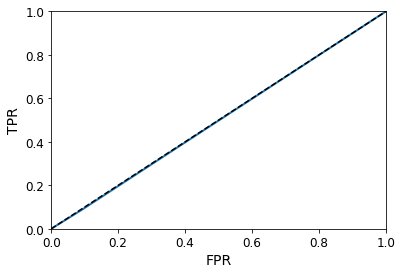

In [235]:
from sklearn.dummy import DummyClassifier
dmy_clf = DummyClassifier()
y_probas_dmy = cross_val_predict(dmy_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_scores_dmy = y_probas_dmy[:,1]
fpr_r, tpr_r, thresholds_r = roc_curve(y_train_5, y_scores_dmy)
plot_roc_curve(fpr_r, tpr_r) # 不用thresholds_r，就两变量

#### gridsearch提高准确率

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [{"weights": ["uniform", "distance"], "n_neighbors": [3,4,5]}]
knn_clf = KNeighborsClassifier()
# 训练集分5分 留一个验证 一轮5次 6个参数组合 总共30次fit
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3, n_jobs=-1) 
grid_search.fit(X_train, y_train) # 比较耗时间

In [ ]:
grid_search.best_params_ # 4, distance
grid_search.best_score_ # 0.97325

#### data aug.

In [257]:
from scipy.ndimage.interpolation import shift
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1]) # [-1]: to 1D, 具体多少自己算

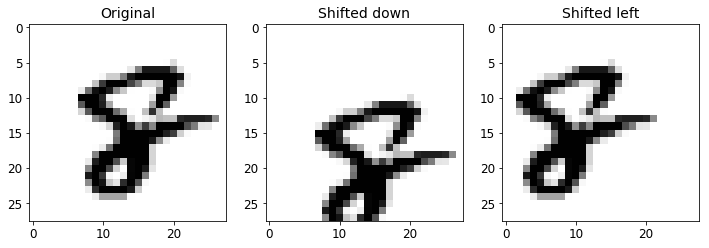

In [260]:
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape((28,28)), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [262]:
X_train_aug = [X_train]
y_train_aug = [y_train]
for dx, dy in((1, 0), (-1, 0), (0, 1), (0, -1)):
    img_aug = np.apply_along_axis(shift_image, arr=X_train, axis=1, dx=dx, dy=dy)
    X_train_aug.append(img_aug)
    y_train_aug.append(y_train)
    
X_train_aug = np.concatenate(X_train_aug)
y_train_aug = np.concatenate(y_train_aug)

In [264]:
X_train_aug.shape

(300000, 784)

In [265]:
shuffle_idx = np.random.permutation(300000)
X_train_aug = X_train_aug[shuffle_idx]
y_train_aug = y_train_aug[shuffle_idx]

In [ ]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)
knn_clf.fit(X_train_aug, y_train_aug)
y_test_knn_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_test_knn_pred) # 0.9763, 0.5% up!

### Titanic数据集

In [270]:
import os
import pandas as pd

TITANIC_PATH = os.path.join("datasets", "titanic")
def load_titanic_data(filename, path=TITANIC_PATH):
    file_path = os.path.join(path, filename)
    return pd.read_csv(file_path)

In [271]:
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

In [272]:
train_data.head() # Parch: 船上的子女和父母人数 Fare: 票价 Embarked: 上船地点

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [273]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [274]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [277]:
train_data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [278]:
train_data["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [282]:
train_data["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

#### preprocessing: num. col. & cat. col.

In [283]:
from sklearn.base import BaseEstimator, TransformerMixin

# 该transformer从dataFrame中选取若干列
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]  

In [285]:
# num列的pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
    ("select_numeric", DataFrameSelector(["Age", "SibSp", "Parch", "Fare"])),
    ("imputer", SimpleImputer(strategy="median"))
])

In [287]:
num_pipeline.fit_transform(train_data)

array([[22.    ,  1.    ,  0.    ,  7.25  ],
       [38.    ,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ],
       [26.    ,  0.    ,  0.    , 30.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ]])

In [300]:
# string列的imputer: fill with most freq.
class MostFreqImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # 从cat列里面找到每个列出现最多的data 用它来填充NaN
        self.most_freq_ = pd.Series([X[col].value_counts().index[0] for col in X], index=X.columns)
        return self
    def transform(self, X, y=None): # self is Obj. of class Most.., X is train_data
        return X.fillna(self.most_freq_)

In [301]:
from sklearn.preprocessing import OneHotEncoder
cat_pipeline = Pipeline([
    ("select_cat", DataFrameSelector(["Pclass", "Sex", "Embarked"])),
    ("imputer", MostFreqImputer()),
    ("cat_encoder", OneHotEncoder(sparse=False))
])

In [303]:
cat_pipeline.fit_transform(train_data).shape

(891, 8)

In [304]:
# 将两个pipline组合起来
from sklearn.pipeline import FeatureUnion

preprocess_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline)
])

In [307]:
X_train = preprocess_pipeline.fit_transform(train_data)
y_train = train_data["Survived"]

In [308]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(preprocess_pipeline.fit_transform(test_data)) # pd.to_csv(pd.DataFrame(y_pred), header=None, index=None)

In [310]:
svm_clf

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [311]:
from sklearn.model_selection import cross_val_score
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.7365250822835092

In [315]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
type(forest_scores)

numpy.ndarray

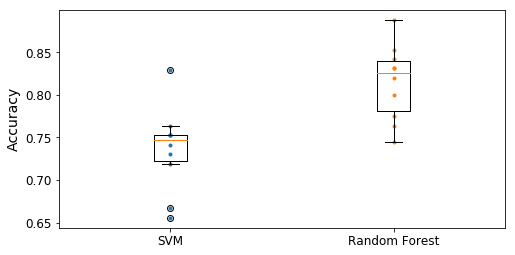

In [316]:
plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".") # 10个坐标
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM","Random Forest")) # 箱型图
plt.ylabel("Accuracy", fontsize=14)
plt.show()

In [319]:
# 特征工程: 年龄分类 将numerical -> catagorical
train_data["AgeBucket"] = train_data["Age"] // 15 * 15 # [0-15],[15-30],...
train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean() # dataFrame

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


### 垃圾邮件分类 

In [1]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "http://spamassassin.apache.org/old/publiccorpus/"
HAM_URL = DOWNLOAD_ROOT + "20030228_easy_ham.tar.bz2"
SPAM_URL = DOWNLOAD_ROOT + "20030228_spam.tar.bz2"
SPAM_PATH = os.path.join("datasets", "spam")

# 网络问题？上这个网站手动下
def fetch_spam_data(spam_path=SPAM_PATH): # default path: SP..
    if not os.path.isdir(spam_path):
        os.makedirs(spam_path)
    for filename, url in (("ham.tar.bz2", HAM_URL), ("spam.tar.bz2", SPAM_URL)):
        path = os.path.join(spam_path, filename)
        if not os.path.isfile(path):
            urllib.request.urlretrieve(url, path)
        tar_bz2_file = tarfile.open(path)
        tar_bz2_file.extractall(path=SPAM_PATH)
        tar_bz2_file.close()

In [2]:
fetch_spam_data()

In [9]:
!pwd
sorted(os.listdir("."))

/Users/chris/tensorflow/handsonml


['.DS_Store',
 '.ipynb_checkpoints',
 '01_landscape.ipynb',
 '02_end2end_ml_project.ipynb',
 '03classification.ipynb',
 'datasets',
 'final_model.pkl',
 'fundamentals',
 'images',
 '未命名.ipynb']

In [11]:
HAM_DIR = os.path.join(SPAM_PATH, "easy_ham")
SPAM_DIR = os.path.join(SPAM_PATH, "spam")
ham_filenames = [name for name in sorted(os.listdir(HAM_DIR)) if len(name) > 20]
spam_filenames = [name for name in sorted(os.listdir(SPAM_DIR)) if len(name) > 20] #里面有个cmd 用len来过滤掉 & 排序

In [13]:
len(spam_filenames)

500

#### python的email模块处理邮件的header、编码等

In [22]:
import email
import email.policy

def load_email(is_spam, filename, spam_path=SPAM_PATH): # 有默认值的放参数list后面 之后调用时不用传值了
    directory = "spam" if is_spam else "easy_ham"
    with open(os.path.join(spam_path, directory, filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f) # 没有return 就成NoneType了

In [23]:
ham_email = [load_email(is_spam=False, filename=name) for name in ham_filenames]
spam_email = [load_email(is_spam=True, filename=name) for name in spam_filenames]

In [28]:
print(ham_email[1].get_content().strip()) # EmailMessage Object

Martin A posted:
Tassos Papadopoulos, the Greek sculptor behind the plan, judged that the
 limestone of Mount Kerdylio, 70 miles east of Salonika and not far from the
 Mount Athos monastic community, was ideal for the patriotic sculpture. 
 
 As well as Alexander's granite features, 240 ft high and 170 ft wide, a
 museum, a restored amphitheatre and car park for admiring crowds are
planned
---------------------
So is this mountain limestone or granite?
If it's limestone, it'll weather pretty fast.

------------------------ Yahoo! Groups Sponsor ---------------------~-->
4 DVDs Free +s&p Join Now
http://us.click.yahoo.com/pt6YBB/NXiEAA/mG3HAA/7gSolB/TM
---------------------------------------------------------------------~->

To unsubscribe from this group, send an email to:
forteana-unsubscribe@egroups.com

 

Your use of Yahoo! Groups is subject to http://docs.yahoo.com/info/terms/


#### 检查邮件的结构（可能包含多种结构）

In [56]:
def get_email_stucture(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload() # payload?
    if isinstance(payload, list):
        # f''里面的“”是字面量，为什么不能将[]换行拆开，EOL error?
        return f'mulltipart({", ".join([get_email_stucture(sub_) for sub_ in payload])})'
    else:
        return email.get_content_type()

In [52]:
f'mu({", ".join(["sj", "jfei"])})'

'mu(sj, jfei)'

In [53]:
str2 = """aaa'''bbb"""
str2

"aaa'''bbb"

In [46]:
from collections import Counter

def structures_counter(emails):
    counter = Counter()
    for email in emails:
        structure = get_email_stucture(email)
        counter[structure] += 1
    return counter

In [57]:
structures_counter(ham_email).most_common() # 垃圾邮件结构更丰富🐴

[('text/plain', 2408),
 ('mulltipart(text/plain, application/pgp-signature)', 66),
 ('mulltipart(text/plain, text/html)', 8),
 ('mulltipart(text/plain, text/plain)', 4),
 ('mulltipart(text/plain)', 3),
 ('mulltipart(text/plain, application/octet-stream)', 2),
 ('mulltipart(text/plain, text/enriched)', 1),
 ('mulltipart(text/plain, application/ms-tnef, text/plain)', 1),
 ('mulltipart(mulltipart(text/plain, text/plain, text/plain), application/pgp-signature)',
  1),
 ('mulltipart(text/plain, video/mng)', 1),
 ('mulltipart(text/plain, mulltipart(text/plain))', 1),
 ('mulltipart(text/plain, application/x-pkcs7-signature)', 1),
 ('mulltipart(text/plain, mulltipart(text/plain, text/plain), text/rfc822-headers)',
  1),
 ('mulltipart(text/plain, mulltipart(text/plain, text/plain), mulltipart(mulltipart(text/plain, application/x-pkcs7-signature)))',
  1),
 ('mulltipart(text/plain, application/x-java-applet)', 1)]

In [58]:
structures_counter(spam_email).most_common()

[('text/plain', 218),
 ('text/html', 183),
 ('mulltipart(text/plain, text/html)', 45),
 ('mulltipart(text/html)', 20),
 ('mulltipart(text/plain)', 19),
 ('mulltipart(mulltipart(text/html))', 5),
 ('mulltipart(text/plain, image/jpeg)', 3),
 ('mulltipart(text/html, application/octet-stream)', 2),
 ('mulltipart(text/plain, application/octet-stream)', 1),
 ('mulltipart(text/html, text/plain)', 1),
 ('mulltipart(mulltipart(text/html), application/octet-stream, image/jpeg)',
  1),
 ('mulltipart(mulltipart(text/plain, text/html), image/gif)', 1),
 ('multipart/alternative', 1)]

In [62]:
# spam_email[0].items() EmailMessage -> header items(list)
for header, value in spam_email[0].items():
    print(header, ":", value)

Return-Path : <12a1mailbot1@web.de>
Delivered-To : zzzz@localhost.spamassassin.taint.org
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.spamassassin.taint.org (Postfix) with ESMTP id 136B943C32	for <zzzz@localhost>; Thu, 22 Aug 2002 08:17:21 -0400 (EDT)
Received : from mail.webnote.net [193.120.211.219]	by localhost with POP3 (fetchmail-5.9.0)	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 13:17:21 +0100 (IST)
Received : from dd_it7 ([210.97.77.167])	by webnote.net (8.9.3/8.9.3) with ESMTP id NAA04623	for <zzzz@spamassassin.taint.org>; Thu, 22 Aug 2002 13:09:41 +0100
From : 12a1mailbot1@web.de
Received : from r-smtp.korea.com - 203.122.2.197 by dd_it7  with Microsoft SMTPSVC(5.5.1775.675.6);	 Sat, 24 Aug 2002 09:42:10 +0900
To : dcek1a1@netsgo.com
Subject : Life Insurance - Why Pay More?
Date : Wed, 21 Aug 2002 20:31:57 -1600
MIME-Version : 1.0
Message-ID : <0103c1042001882DD_IT7@dd_it7>
Content-Type : text/html; charset="iso-8859-1"
Content-Transfer-Encoding : qu

In [64]:
spam_email[0]["Subject"] # EmailMessage is list-like object

'Life Insurance - Why Pay More?'

#### train test set

In [65]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.array(ham_email + spam_email)
y = np.array([0] * len(ham_email) + [1] * len(spam_email))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [66]:
X_test[:5]

array([<email.message.EmailMessage object at 0x10996a978>,
       <email.message.EmailMessage object at 0x109c36400>], dtype=object)

* [regular expression .* vs .*?](https://stackoverflow.com/questions/3075130/what-is-the-difference-between-and-regular-expressions) 
* [re grammer](https://www.runoob.com/regexp/regexp-syntax.html)

In [76]:
import re
string = 'eeeAiiZuuuuAoooZeeAZee'
re.findall('A.*?Z',string) # non-greedy: 先尽可能的少match . 再逐渐增加 .
#re.findall('A.*Z',string) # greedy: 一直match . 直到unmatch再回溯找Z

['AiiZ', 'AoooZ', 'AZ']

In [75]:
from html import unescape
t =  '&lt;abc&gt;'
txt = unescape(t)
txt

'<abc>'

#### html -> text
* drop `<head>` section
* `<a>` -> HYPERLINK
* drop all html tag
* multi newlines -> single newline
* unescape html entites (`&gt;` or `&nbsp;`) <br/> re.M multi-line <br/> re.S: match all .(\n included) <br/> re.I: case-insensitive

In [78]:
import re
from html import unescape

def html_to_plain_text(html):
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I) 
    text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
    text = re.sub('<.*?>', '', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)

In [80]:
html_spam_emails = [email for email in X_train[y_train==1] if get_email_stucture(email) == 'text/html']
sample = html_spam_emails[7]
print(sample.get_content().strip()[:1000], "...")

<HTML><HEAD><TITLE></TITLE><META http-equiv="Content-Type" content="text/html; charset=windows-1252"><STYLE>A:link {TEX-DECORATION: none}A:active {TEXT-DECORATION: none}A:visited {TEXT-DECORATION: none}A:hover {COLOR: #0033ff; TEXT-DECORATION: underline}</STYLE><META content="MSHTML 6.00.2713.1100" name="GENERATOR"></HEAD>
<BODY text="#000000" vLink="#0033ff" link="#0033ff" bgColor="#CCCC99"><TABLE borderColor="#660000" cellSpacing="0" cellPadding="0" border="0" width="100%"><TR><TD bgColor="#CCCC99" valign="top" colspan="2" height="27">
<font size="6" face="Arial, Helvetica, sans-serif" color="#660000">
<b>OTC</b></font></TD></TR><TR><TD height="2" bgcolor="#6a694f">
<font size="5" face="Times New Roman, Times, serif" color="#FFFFFF">
<b>&nbsp;Newsletter</b></font></TD><TD height="2" bgcolor="#6a694f"><div align="right"><font color="#FFFFFF">
<b>Discover Tomorrow's Winners&nbsp;</b></font></div></TD></TR><TR><TD height="25" colspan="2" bgcolor="#CCCC99"><table width="100%" border="0" 

In [82]:
print(html_to_plain_text(sample.get_content().strip())[:1000], "...") # 先to_text 再取前1000个。。。


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Watch for analyst "Strong Buy Recommendations" and several advisory newsletters picking CBYI.  CBYI has filed to be traded on the OTCBB, share prices historically INCREASE when companies get listed on this larger trading exchange. CBYI is trading around 25 cents and should skyrocket to $2.66 - $3.25 a share in the near future.
Put CBYI on your watch list, acquire a position TODAY.
REASONS TO INVEST IN CBYI
A profitable company and is on track to beat ALL earnings estimates!
One of the FASTEST growing distributors in environmental & safety equipment instruments.
Excellent management team, several EXCLUSIVE contracts.  IMPRESSIVE client list including the U.S. Air Force, Anheuser-Busch, Chevron Refining and Mitsubishi Heavy Industries, GE-Energy & Environmental Research.
RAPIDLY GROWING INDUSTRY
Industry revenues exceed $900 million, estimates indicate that there could be as much as $25 billi

In [84]:
def email_to_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in('text/plain', 'text/html'):
            continue
        try:
            content = part.get_content()
        except:
            content = str(part.get_payload())
        if ctype == 'text/plain':
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)

In [85]:
print(email_to_text(sample)[:100], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Wat ...


#### nltk处理分词

In [87]:
import nltk
stemmer = nltk.PorterStemmer()
for word in("Computations", "Computation", "Computing", "Computed", "Compute", "Compulsive"):
    print(word, '=>', stemmer.stem(word))

Computations => comput
Computation => comput
Computing => comput
Computed => comput
Compute => comput
Compulsive => compuls


In [88]:
!pip install urlextract

Looking in indexes: http://mirrors.aliyun.com/pypi/simple/
You are using pip version 19.0.3, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [95]:
try:
    import urlextract
    url_extractor = urlextract.URLExtract()
    print(urlextractor.find_urls("Will it detect github.com and https://youtu.be/7Pq-S557XQU?t=3m32s"))
except ImportError:
    print("ERROR: urlextract module needed!")
    urlextractor = None


['github.com', 'https://youtu.be/7Pq-S557XQU?t=3m32s']


[regex grammer](https://docs.python.org/3/library/re.html)
* r'': raw string
* \d: numerical 
* ?: is for non capturing group 非引用捕获 提高速度
* [eE]: e or E
* match: 3.5, 3.1e10
* \W: not `<alphanumeric> & _`

In [119]:
from sklearn.base import BaseEstimator, TransformerMixin

class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, lower_case=True, remove_punctuation=True,
                 replace_urls=True, replace_numbers=True, stemming=True):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_transformed = []
        for email in X:
            text = email_to_text(email) or ""
            if self.lower_case:
                text = text.lower()
            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(text)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    text = text.replace(url, " URL ")
            # re.sub里面没有r''也一样，不过正则表达式里面一般都是有r的
            if self.replace_numbers: # 数字-> flag
                text = re.sub(r'\d+(?:\.\d*(?:[eE]\d+))?', ' NUMBER ', text) # NUMBER应该要有空格的 是一个特征
            # 普通的string: \\ 才是\, r'': byte string, ur'': unicode string
            if self.remove_punctuation: # 去掉标点符号
                text = re.sub(r'\W+', ' ', text, flags=re.M)
            word_counts = Counter(text.split())
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter() # dict-like object
                for word, count in word_counts.items(): # -> dict's key & value
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed) # dict list -> ndarray

#### 核心思想：数据清洗后根据高频词来做回归分析，提取的特征有 URL数、数字数、相同词源的数

In [120]:
from scipy.sparse import csr_matrix
# Compressed Sparse Row matrix 大部分是0，row col对应的位置是data
class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    def fit(self, X, y=None):
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, 10) # ?
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.most_common_ = most_common
        self.vocabulary_ = {word: index + 1 for index, (word, count) in enumerate(most_common)}
        return self
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                # 0: key找不到时的返回的默认值，查字典 -> 找到该词对应的index(特征：高频词)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count) # word排第几列
        return csr_matrix((data, (rows, cols)), shape=(len(X), self.vocabulary_size + 1)) # id is 1-based, so + 1

In [121]:
from sklearn.pipeline import Pipeline

preprocess_pipeline = Pipeline([
    ("email_to_wordcount", EmailToWordCounterTransformer()),
    ("wordcount_to_vector", WordCounterToVectorTransformer()),
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)
X_train_transformed.shape

(2400, 1001)

In [122]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_clf = LogisticRegression(solver="liblinear", random_state=42)
score = cross_val_score(log_clf, X_train_transformed, y_train, cv=3, verbose=3)
score.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV]  ................................................................
[CV] ................................... , score=0.9875, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=0.98625, total=   0.1s
[CV]  ................................................................
[CV] .................................. , score=0.99125, total=   0.1s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished


0.9883333333333333

In [129]:
from sklearn.metrics import precision_score, recall_score

X_test_transformed = preprocess_pipeline.transform(X_test) # 测试集数据transform

log_clf = LogisticRegression(solver="liblinear", random_state=42) # 1、new 分类器对象
log_clf.fit(X_train_transformed, y_train) # 2、fit

y_pred = log_clf.predict(X_test_transformed) # 3、predict

print(f"Precision: {100 * precision_score(y_test, y_pred):.2f}")
print(f"Recall: {100 * recall_score(y_test, y_pred):.2f}")

Precision: 94.90
Recall: 97.89


In [105]:
np.dot(np.array([2,1,4]), np.array([[3], [4], [2]])) # not a scaler, a single matrix

array([18])

In [135]:
a = f"{3+1:2d}et"
a

' 4et'